In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import numpy as np

In [3]:

# Load the dataset
df = pd.read_csv("combined_nps(absolute coconut).txt", header=None, names=["smiles"])

# Initialize RDKit molecules and scaffolds
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df['scaffold'] = df['mol'].apply(lambda x: MurckoScaffold.MurckoScaffoldSmiles(mol=x, includeChirality=False))

# Create a mapping from scaffolds to indices
scaffold_to_indices = defaultdict(list)
for idx, scaffold in enumerate(df['scaffold']):
    scaffold_to_indices[scaffold].append(idx)

# Shuffle and split scaffolds into train, val, test
scaffolds = list(scaffold_to_indices.keys())
np.random.shuffle(scaffolds)
num_train = int(0.8 * len(scaffolds))
num_val = int(0.1 * len(scaffolds))

train_scaffolds = set(scaffolds[:num_train])
val_scaffolds = set(scaffolds[num_train:num_train + num_val])
test_scaffolds = set(scaffolds[num_train + num_val:])

# Get indices for each dataset
train_indices = [idx for scaffold in train_scaffolds for idx in scaffold_to_indices[scaffold]]
val_indices = [idx for scaffold in val_scaffolds for idx in scaffold_to_indices[scaffold]]
test_indices = [idx for scaffold in test_scaffolds for idx in scaffold_to_indices[scaffold]]

# Extract subsets
train_smiles = df.loc[train_indices, 'smiles']
val_smiles = df.loc[val_indices, 'smiles']
test_smiles = df.loc[test_indices, 'smiles']

# Save to files
#train_smiles.to_csv("train(scaffold).txt", index=False, header=False)
#val_smiles.to_csv("eval(scaffold).txt", index=False, header=False)
#test_smiles.to_csv("test(scaffold).txt", index=False, header=False)


[19:48:06] WARNING: not removing hydrogen atom without neighbors


In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

[21:37:18] WARNING: not removing hydrogen atom without neighbors


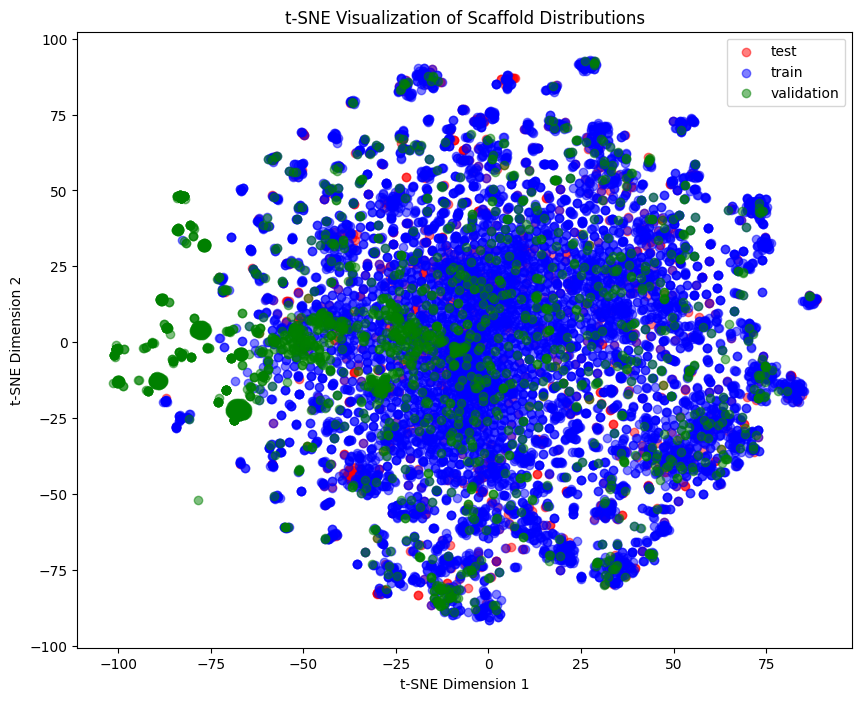

In [6]:
# Load the dataset
df = pd.read_csv('combined_nps(absolute coconut).txt', header=None, names=['smiles'])

# Initialize RDKit molecules, handle possible None values directly here
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df = df.dropna(subset=['mol'])  # Drop entries where molecules couldn't be created

# Sample 50% of the data to reduce processing load
df_sampled = df.sample(frac=0.01, random_state=42)

# Generate fingerprints for each molecule, include conditional handling for None values
df_sampled['fp'] = df_sampled['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) if x else None)
df_sampled = df_sampled.dropna(subset=['fp'])  # Ensure all entries have fingerprints

# Assign dataset labels based on scaffold membership
df_sampled['dataset'] = 'test'  # Default to 'test'
df_sampled.loc[df_sampled.index.isin(train_indices), 'dataset'] = 'train'
df_sampled.loc[df_sampled.index.isin(val_indices), 'dataset'] = 'validation'

# Prepare data for t-SNE
fps = np.array([list(fp) for fp in df_sampled['fp']])
dataset_labels = df_sampled['dataset']

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_fps = tsne.fit_transform(fps)

# Plotting
plt.figure(figsize=(10, 8))
colors = {'train': 'blue', 'validation': 'green', 'test': 'red'}
for label in np.unique(dataset_labels):
    indices = dataset_labels == label
    plt.scatter(transformed_fps[indices, 0], transformed_fps[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.title('t-SNE Visualization of Scaffold Distributions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [8]:
from sklearn.decomposition import PCA

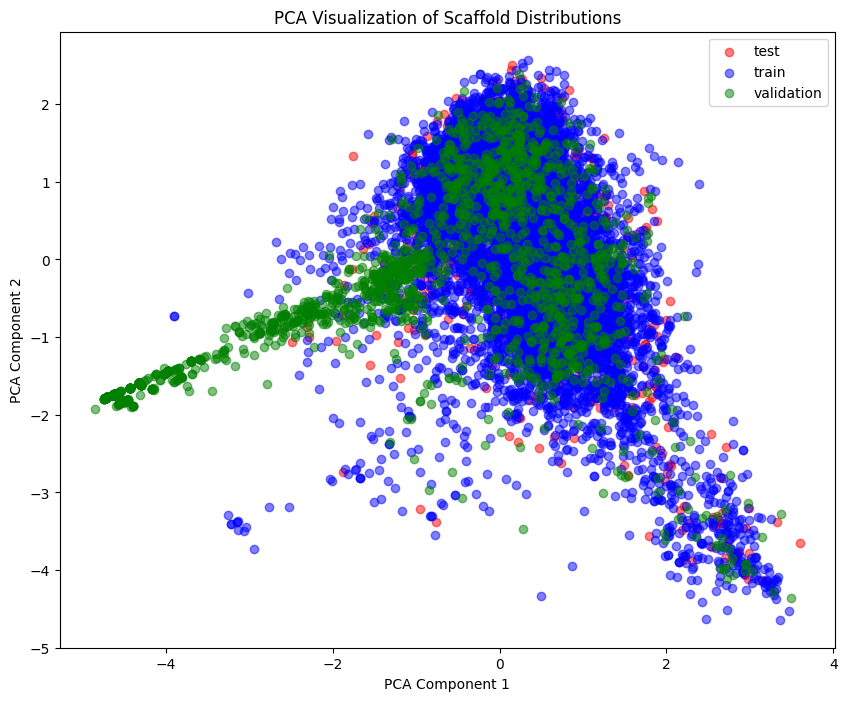

In [9]:
# Prepare data for PCA
fps = np.array([list(fp) for fp in df_sampled['fp']])
dataset_labels = df_sampled['dataset']

# Run PCA
pca = PCA(n_components=2)
transformed_fps = pca.fit_transform(fps)

# Plotting
plt.figure(figsize=(10, 8))
colors = {'train': 'blue', 'validation': 'green', 'test': 'red'}
for label in np.unique(dataset_labels):
    indices = dataset_labels == label
    plt.scatter(transformed_fps[indices, 0], transformed_fps[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.title('PCA Visualization of Scaffold Distributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

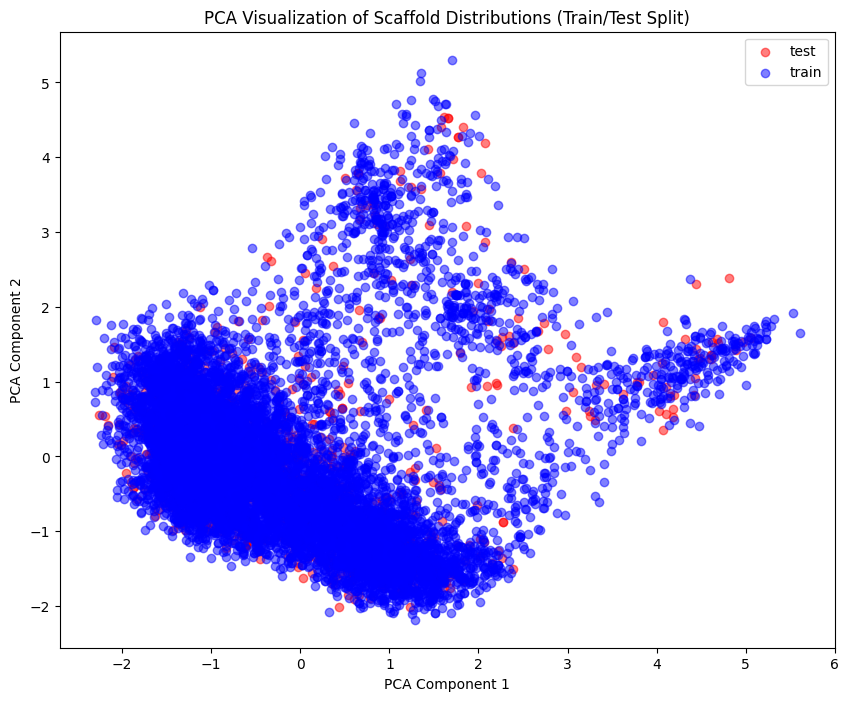

In [10]:
# Filter to only include train and test sets
df_sampled = df_sampled[df_sampled['dataset'].isin(['train', 'test'])]

# Prepare data for PCA
fps = np.array([list(fp) for fp in df_sampled['fp']])
dataset_labels = df_sampled['dataset']

# Run PCA
pca = PCA(n_components=2)
transformed_fps = pca.fit_transform(fps)

# Plotting
plt.figure(figsize=(10, 8))
colors = {'train': 'blue', 'test': 'red'}
for label in np.unique(dataset_labels):
    indices = dataset_labels == label
    plt.scatter(transformed_fps[indices, 0], transformed_fps[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.title('PCA Visualization of Scaffold Distributions (Train/Test Split)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

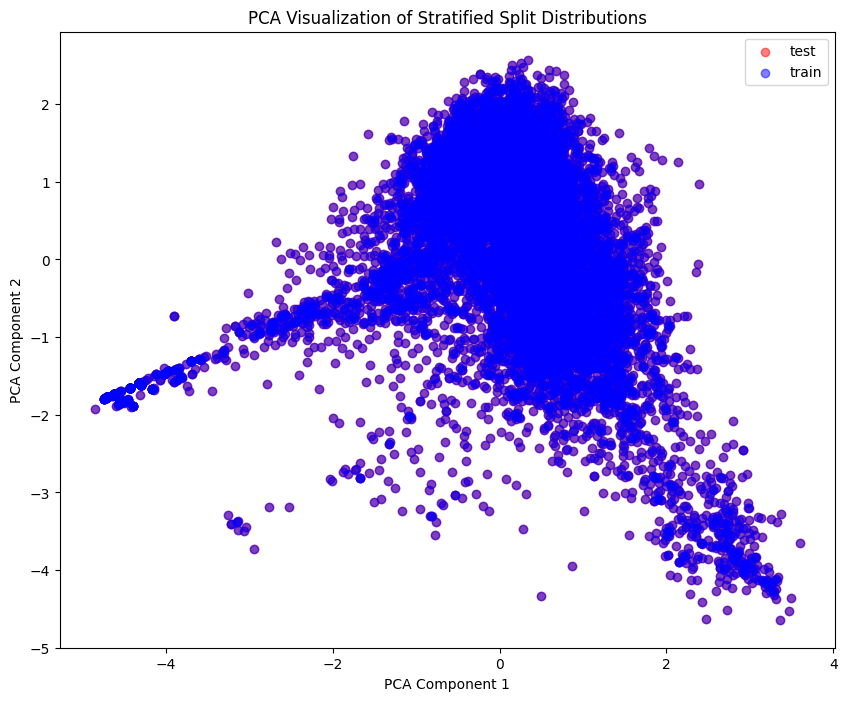

In [12]:
# Load the datasets
train_df = pd.read_csv('train.txt', header=None, names=['smiles'])
train_df = df.sample(frac=0.01, random_state=42)
test_df = pd.read_csv('test.txt', header=None, names=['smiles'])
test_df = df.sample(frac=0.01, random_state=42)

# Initialize RDKit molecules, handle possible None values directly here
train_df['mol'] = train_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
train_df = train_df.dropna(subset=['mol'])  # Drop entries where molecules couldn't be created

test_df['mol'] = test_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
test_df = test_df.dropna(subset=['mol'])  # Drop entries where molecules couldn't be created

# Generate fingerprints for each molecule, include conditional handling for None values
train_df['fp'] = train_df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) if x else None)
train_df = train_df.dropna(subset=['fp'])  # Ensure all entries have fingerprints

test_df['fp'] = test_df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048) if x else None)
test_df = test_df.dropna(subset=['fp'])  # Ensure all entries have fingerprints

# Combine datasets for PCA
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
combined_df = pd.concat([train_df, test_df])

# Prepare data for PCA
fps = np.array([list(fp) for fp in combined_df['fp']])
dataset_labels = combined_df['dataset']

# Run PCA
pca = PCA(n_components=2)
transformed_fps = pca.fit_transform(fps)

# Plotting
plt.figure(figsize=(10, 8))
colors = {'train': 'blue', 'test': 'red'}
for label in np.unique(dataset_labels):
    indices = dataset_labels == label
    plt.scatter(transformed_fps[indices, 0], transformed_fps[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.title('PCA Visualization of Stratified Split Distributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

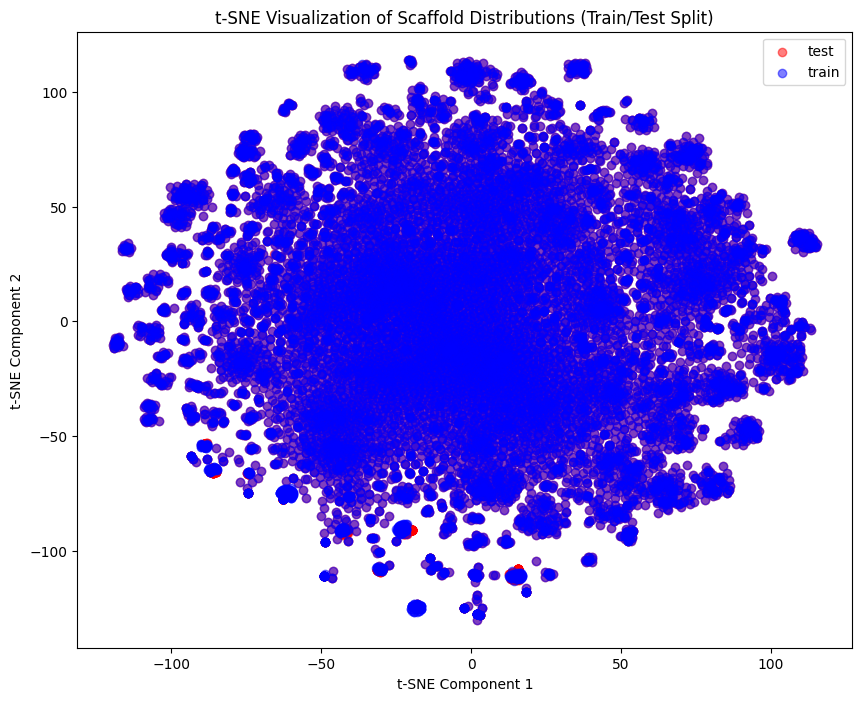

In [13]:
# Prepare data for t-SNE
fps = np.array([list(fp) for fp in combined_df['fp']])
dataset_labels = combined_df['dataset']

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_fps = tsne.fit_transform(fps)

# Plotting
plt.figure(figsize=(10, 8))
colors = {'train': 'blue', 'test': 'red'}
for label in np.unique(dataset_labels):
    indices = dataset_labels == label
    plt.scatter(transformed_fps[indices, 0], transformed_fps[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.title('t-SNE Visualization of Scaffold Distributions (Train/Test Split)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()